# Orthohelium population

Writing a differential equation for the change in ortho-state:

$$\frac{d n^{o}}{dt} = \frac{3}{4} \alpha n_e n_{He II} 
- \Sigma n_i^o \int_{E_i} F_{\nu} B_{i,\inf} \ d\nu 
- \Sigma n_i^o A_i^{p}
- \Sigma n_i^o k n_e
$$


Here, the first term is recombination, second term is photo-ionization, third term is the E1 decay to ground state (ie. slow for the ground state) and fourth term is electron collision. 

We will assume the energy-levels of the triplet is Boltzman-distributed: 

$n_i^o= n_0^o e^{-(E_i-E_0^o)/kT}$

In [497]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import minimize
from dataclasses import dataclass
from dataclasses import dataclass, field
import astropy.units as u
import astropy.constants as const
from astropy.modeling.physical_models import BlackBody
from functools import lru_cache

# small helper function to make a numpy array field with a default value
make_np_field = lambda list, multiplier=1: field(default_factory=lambda: np.array(list)*multiplier)

# constants, in cgs units
erg_per_eV = u.eV.to(u.erg) # erg/eV
k_B = const.k_B.cgs.value  # erg/K# calculate density profile at t=1 day

rho = lambda v,t, rho0, p=5, v_0=0.2, t_0=1 : rho0 * (v/v_0)**-p * (t/t_0)**-3
# M = int dM/dV*dV/dr*dr/dv wrt dv
# r = 1 day * v
# M = int rho(v)*dV/dr*dr/dv wrt dv
# output in g/c
def dMdv(v, t):
    v = v*const.c
    t = t*u.day
    dr_dv = 1*u.day
    r = 1*u.day * v
    dV_dr = 4*np.pi*r**2
    dM_dV = rho(v, t, 1*u.g/u.cm**3, v_0=0.2*const.c, t_0=1*u.day)
    return (dM_dV.cgs * dV_dr.cgs * dr_dv.cgs * const.c).cgs.value

@lru_cache
def get_density_profile(M_ej = 0.04, atomic_mass=4, mass_fraction=0.002):
    M_ej = M_ej * u.M_sun
    atomic_mass = atomic_mass * u.u
    # we calculate the density profile at t=1 day, and normalize it to 0.04 solar mass
    rho_0 =  M_ej / (quad(dMdv, 0.1, 0.5, args=1)[0] * u.g/u.cm**3)
    number_density_0 = (rho_0 * mass_fraction / atomic_mass).cgs.value
    print(rho_0, mass_fraction, atomic_mass, number_density_0)
    return lambda v, t: rho(v, t, number_density_0)

# Environment class, contains all the parameters of the environment
# and calculates the derived parameters constant for all ortho populations.
# can be initialized with the default values as Environment(), or with custom values
# as Environment(t_d=1.43, T=4000, UV_shielding=0.9). 
@dataclass
class Environment:
    # input values
    t_d: float = 1.43 # days. Yes Days. The second cgs unit of time, apparently.
    T: float = 4000  # K
    M_ejecta: float = 0.04 # solar masses ejected
    mass_fraction: float = 0.002 # mass fraction of helium
    atomic_mass: float = 4 # atomic mass of helium [u]
    photosphere_velocity: float = 0.3 # photosheric velocity as a fraction of c
    
    # Level properties. Can be lengthened to include more levels
    # Must all be ordered the same way
    multiplicities: np.ndarray = make_np_field([1,3]) # 1 for singlet, 3 for triplet
    energies: np.ndarray = make_np_field([19.82, 20.96], erg_per_eV)  # eV
    """ 
    A_rates: 
    From 3P to singlet ground, A = 1.764e+02 (ie. time-scale of 0.005 s)
    From 3S to singlet ground, A = 1.272e-04 (ie. time-scale of hours)
    Thus, the dominant path-way down should be from the triplet first exited state. 
    """
    A_rates: np.ndarray = make_np_field([1.272e-04, 1.764e+02])  #s^-1
    names: list = field(default_factory=lambda: ["1s2s_ortho", "1s2p_ortho"]) # names of levels in cross-section files
    
    
    # dervied values, calculated in __post_init__ based on the above values
    bolzmann_factors : np.ndarray = None # From T and energies
    ionization_rates : np.ndarray = None # From T and energies
    collision_k : np.ndarray = None
    alpha: float = None #cm^3/s, calculate based on temp
    n_e: float = None # count/cm^3	
    n_HeII: float = None # count/cm^3

    # Calculate derived values based on the input values
    def __post_init__(self):
        self.bolzmann_factors = self.calculate_bolzmann_factors(self.energies, self.T)
        self.ionization_rates = self.calculate_ionization_integrals(self.T, self.names)
        self.collision_k = self.calculate_collision_k(self.T, self.multiplicities)
        self.alpha = self.calculate_alpha(self.T)
        self.n_e, self.n_HeII = self.calculate_number_densities(self.t_d, self.M_ejecta, self.atomic_mass, self.mass_fraction, self.photosphere_velocity)

    # Calculate the bolzmann factors for a given temperature
    @staticmethod
    def calculate_bolzmann_factors(E, T):
        return np.exp(-(E-E[0])/(k_B*T))

    # integrate product between shielded BB and crossection
    #@staticmethod
    #def calculate_ionization_integrals(T, names):
    #    # make cthe blackbody spectrum, scaled by the UV shielding and per-wavelength
    #    bb = BlackBody(T * u.K, scale=1*u.Unit("erg/(nm s sr cm2)")) 
    #    ionization_rates = []
    #    for name in names:
    #        E, sigma = np.fliplr(np.loadtxt(name + "_ionization.csv", unpack=True))
    #        E = (E * u.Ry).cgs
    #        wl = E.to(u.nm, equivalencies=u.spectral())
    #        sigma = (sigma * u.Mbarn).cgs
    #        ionization_flux_article = np.pi*2*u.sr * sigma * (bb(wl)/E)
    #        ionization_rates.append(np.trapz(x=wl, y=ionization_flux_article).to(1/u.s).value)
    #    return np.array(ionization_rates)
    
    # integrate product between shielded BB and crossection
    @staticmethod
    def calculate_ionization_integrals(T, names):
        # make cthe blackbody spectrum, scaled by the UV shielding and per-wavelength
        bb = BlackBody(T * u.K, scale=1*u.Unit("erg/(s Hz sr cm2)")) 
        ionization_rates = []
        for name in names:
            E, sigma = np.loadtxt(name + "_ionization.csv", unpack=True)
            E = (E * u.Ry).cgs
            nu = E.to(u.Hz, equivalencies=u.spectral()) 
            sigma = (sigma * u.Mbarn).cgs
            ionization_flux_article = np.pi*2*u.sr * sigma * (bb(nu)/E)
            ionization_rates.append(np.trapz(x=nu, y=ionization_flux_article).to(1/u.s).value)
        return np.array(ionization_rates)

    # Calculate collisional de-excitation rate
    @staticmethod
    def calculate_collision_k(T, multiplicities):
        return 8.63*10**-6/(np.sqrt(T) * multiplicities)

    # Calculate recombination efficiency
    @staticmethod
    def calculate_alpha(T):   
        T_list = [3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0]
        alpha_list = [1.99e-12, 1.71e-12, 1.47e-12, 1.27e-12, 1.09e-12, 9.32e-13, 
        7.98e-13, 6.84e-13, 5.85e-13, 5.00e-13, 4.28e-13]

        return interp1d(T_list, alpha_list)( np.log10(T) )    

    # Calculate number densities of n_e and n_HeII respectively
    # assuming level population of ortho-HeI is negligible
    # v_line is the velocity of the line in units of c
    @staticmethod
    def calculate_number_densities(t_d, M_ejecta, atomic_mass, Y_He, v_line):
        n_He_profile = get_density_profile(M_ejecta, atomic_mass=atomic_mass, mass_fraction=Y_He)
        
        n_HeII = n_He_profile(v_line, t_d)
        return 1.5e8 * t_d**-3, n_HeII


def recombination_rate(level_pop, env):
    return 3/4 * env.alpha * env.n_e * env.n_HeII

def ionization_rate(level_pop, env):
    return np.sum(level_pop * env.ionization_rates)

def natural_decay_rate(level_pop, env):
    return sum(level_pop * env.A_rates)

def collision_rate(level_pop, env):
    return sum(level_pop * env.collision_k * env.n_e)

def dn_ortho_dt(n0_ortho, env): 
    level_pop = n0_ortho * env.multiplicities * env.bolzmann_factors
    return recombination_rate(level_pop, env) - ionization_rate(level_pop, env) - natural_decay_rate(level_pop, env) - collision_rate(level_pop, env)

def steady_state_n_ortho(env):
    return minimize(dn_ortho_dt, env.n_HeII, args=(env))

def grid_search(property, values):
    results = []
    for value in values:
        env = Environment(**{property:value})
        results.append(steady_state_n_ortho(env))

grid_search("UV_flux", np.geomspace(0.01,100, 5))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


TypeError: Environment.__init__() got an unexpected keyword argument 'UV_flux'

In [498]:
np.pi**2*4

39.47841760435743

1.1924922778585649e-47 cm3 solMass / g 0.002 4.0 u 7139739.930600358


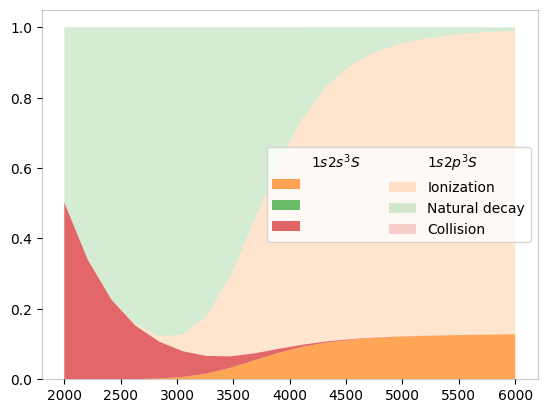

In [499]:
temps = np.linspace(2000,6000, 20)
rates = []
for temp in temps:
    env = Environment(T=temp, t_d=3.43, photosphere_velocity=0.19)
    level_pop =  env.multiplicities * env.bolzmann_factors
    level_pop /= np.sum(level_pop)
    rates.append([
        #recombination_rate(level_pop, env), 
        *(level_pop * env.ionization_rates),
        *(level_pop * env.A_rates),
        *(level_pop * env.collision_k * env.n_e)
        ])
rate_fractions = np.array(rates).T[[0,2,4,1,3,5]] / np.sum(rates, axis=1)
plt.figure()
plt.stackplot(temps, rate_fractions,
            colors=["C1", "C2", "C3", "C1", "C2", "C3"], labels=["Ionization", "Natural decay", "Collision", "Ionization", "Natural decay", "Collision"])
#plt.yscale("log")
children = plt.gca().get_children()    
for child in children[0:3]:
    child.set_alpha(0.7)
for child in children[3:]:
    child.set_alpha(0.2)
handles, labels = plt.gca().get_legend_handles_labels()

empty = plt.plot([],marker="", ls="")[0]
plt.legend([empty, *handles[:3], empty, *handles[3:]], 
    [r"$1s2s^3S$", "", "", "", r"$1s2p^3S$",  "Ionization", "Natural decay", "Collision"], ncol=2, numpoints=1, loc="right")
    #["No prop", "No prop", "Prop +", "Prop +", "Prop *", "Prop *"], ncol=3, numpoints=1)

#order = [5,4,3,2,1,0]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

(2500.0, 5000.0)

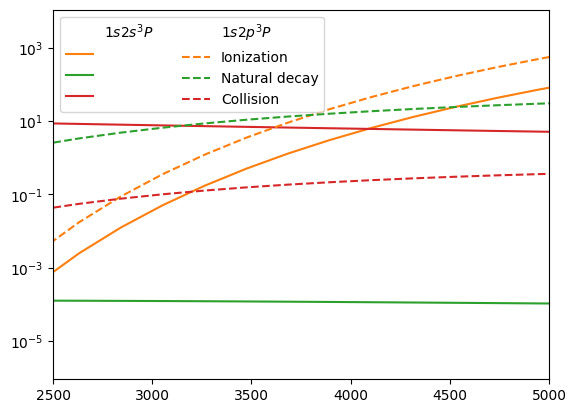

In [500]:
temps = np.linspace(2000,6000, 20)
#recomb_rates = []
#ionization_rates = []
#natural_decay_rates = []
#collision_rates = []
rates = []
for temp in temps:
    env = Environment(T=temp)
    level_pop =  env.multiplicities * env.bolzmann_factors
    level_pop /= np.sum(level_pop)
    rates.append([
        #recombination_rate(level_pop, env), 
        *(level_pop * env.ionization_rates),
        *(level_pop * env.A_rates),
        *(level_pop * env.collision_k * env.n_e)
        ])
    #recomb_rates.append(recombination_rate(level_pop, env))
    #ionization_rates.append(level_pop * env.ionization_rates)
    #natural_decay_rates.append(level_pop * env.A_rates)
    #collision_rates.append(level_pop * env.collision_k * env.n_e)
#plt.plot(temps, recomb_rates, label="recomb", linestyle="--")
#plt.plot(temps, ionization_rates, label=["ionization lower", "ionization upper"])
#plt.plot(temps, natural_decay_rates, label=["natural decay lower", "natural decay upper"])
#plt.plot(temps, collision_rates, label=["collision lower", "collision upper"])
rate_fractions = np.array(rates).T[[0,2,4,1,3,5]] 
plt.figure()
for i, (rates, color) in enumerate(zip(rate_fractions, ["C1", "C2", "C3", "C1", "C2", "C3"])):
    plt.semilogy(temps, rates, color=color, label=" ", linestyle=["-", "--"][(i//3)])
#plt.yscale("log")
handles, labels = plt.gca().get_legend_handles_labels()

empty = plt.plot([],marker="", ls="")[0]
plt.legend([empty, *handles[:3], empty, *handles[3:]], 
    [r"$1s2s^3P$", "", "", "", r"$1s2p^3P$",  "Ionization", "Natural decay", "Collision"], ncol=2, numpoints=1, loc="upper left")
    #["No prop", "No prop", "Prop +", "Prop +", "Prop *", "Prop *"], ncol=3, numpoints=1)

#order = [5,4,3,2,1,0]
#plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.xlim(2500, 5000)

1.0


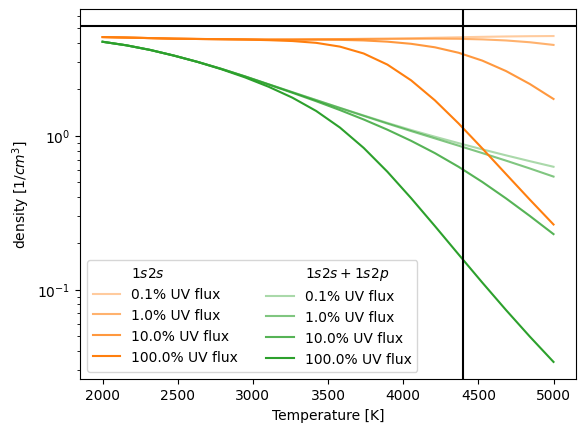

3.5650236647444222


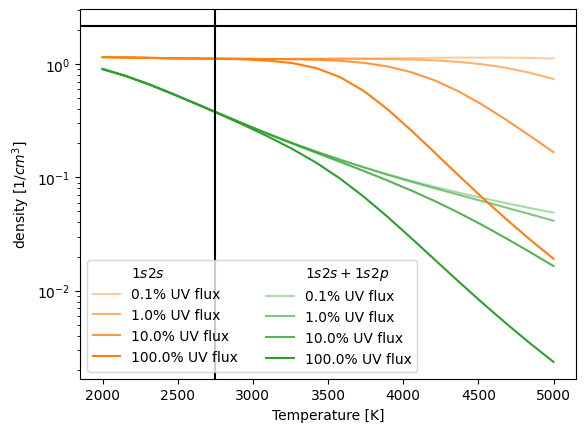

In [501]:
temps = np.linspace(2000,5000, 20)
for t_d, vel, linestyle, T in zip([1.43, 3.41], [0.245, 0.19], ["-", "-"], [4400, 2750]):
    electron_correction = vel**-5/0.245**-5
    print(electron_correction)
    for UV_flux in [0.001, 0.01, 0.1, 1]:
        rates = []
        recombination_rates = []
        for temp in temps:
            env = Environment(T=temp, t_d=t_d, photosphere_velocity=vel)
            level_pop =  env.multiplicities * env.bolzmann_factors
            level_pop /= np.sum(level_pop)
            rates.append([
                #recombination_rate(level_pop, env), 
                *(level_pop * env.ionization_rates*UV_flux),
                *(level_pop * env.A_rates),
                *(level_pop * env.collision_k * env.n_e*electron_correction)
                ])
            R = 3/4 * env.alpha * env.n_e*electron_correction * env.n_HeII
            recombination_rates.append(R)
        rates = np.array(rates)
        recombination_rates = np.array(recombination_rates)

        #env = Environment(T=T, t_d=t_d, photosphere_velocity=vel)
        #R = 3/4 * env.alpha * env.n_e*electron_correction * env.n_HeII
        #level_pop =  env.multiplicities * env.bolzmann_factors
        #level_pop /= np.sum(level_pop)
        #rate_out = level_pop[0] * (env.ionization_rates[0]*UV_flux) + env.A_rates[0] + env.collision_k[0] * env.n_e*electron_correction
        #print(f"{env.n_e=:1.2e}, {env.n_HeII=:1.2e}, pops={np.log10(level_pop*R/rate_out)}")
        alpha = 1+np.log10(UV_flux)/5
        plt.plot(temps, recombination_rates/np.sum(rates[:,0::2], axis=1), alpha=alpha, color="C1", linestyle=linestyle, label=f"{(UV_flux)*100:2.1f}% UV flux")
        #plt.plot(temps, 1/np.sum(rates[:,1::2], axis=1), linestyle=linestyle, label="lifetime (1s2p)")
        plt.plot(temps, recombination_rates/np.sum(rates, axis=1), alpha=alpha, color="C2", linestyle=linestyle, label=f"{(UV_flux)*100:2.1f}% UV flux")
    rho_crit = 7.4 * env.t_d**-1
    plt.axvline(T, color="k", linestyle=linestyle)
    plt.axhline(rho_crit, color="k", linestyle=linestyle)
    handles, labels = plt.gca().get_legend_handles_labels()

    empty = plt.plot([],marker="", ls="")[0]
    plt.legend([empty, *handles[::2], empty, *handles[1::2]], 
        [r"$1s2s$", *labels[::2], r"$1s2s+1s2p$",  *labels[1::2]], ncol=2, numpoints=1, loc="lower left")
    plt.yscale("log")
    plt.xlabel("Temperature [K]")
    plt.ylabel("density $[1/cm^3]$")
    plt.show()

UV flux 0.003
times [1.43 2.42 3.41 4.4 ]
He_II [885103.0488303193, 312804.411194891, 232702.59651082885, 299789.1084900452]
level_pop
23S: [3.78560935 1.42569378 1.08980117 1.41597563]
23P: [0.56168954 0.0641546  0.02662266 0.02620765]
UV flux 1
times [1.43 2.42 3.41 4.4 ]
He_II [885103.0488303193, 312804.411194891, 232702.59651082885, 299789.1084900452]
level_pop
23S: [0.97235361 1.3469491  1.07855657 1.40687367]
23P: [0.1442729  0.06061118 0.02634796 0.02603919]


Text(0, 0.5, 'density $[1/cm^3]$')

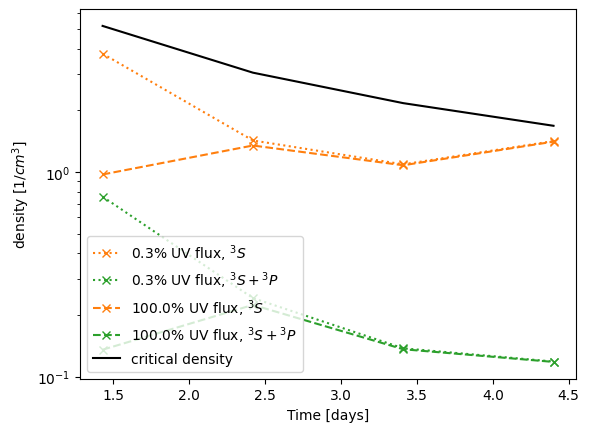

In [502]:
for (UV_flux, linestyle) in zip([0.003, 1], ["dotted", "dashed"]):
    rates = []
    recombination_rates = []
    level_pops = []
    He_II = []
    times = np.array([1.43, 2.42, 3.41, 4.40])
    for t_d, vel, T in zip(times, [0.245, 0.220, 0.190, 0.155], [4400, 3150, 2750, 2600]):
        electron_correction = 1#vel**-5/0.245**-5
        env = Environment(T=T, t_d=t_d, photosphere_velocity=vel)
        level_pop =  env.multiplicities * env.bolzmann_factors #* np.array([1,0.5])
        level_pop /= np.sum(level_pop)
        rates.append([
            #recombination_rate(level_pop, env), 
            *(level_pop * env.ionization_rates*UV_flux),
            *(level_pop * env.A_rates),
            *(level_pop * env.collision_k * env.n_e*electron_correction)
            ])
        R = 3/4 * env.alpha * env.n_e*electron_correction * env.n_HeII #* 1.7
        He_II.append(env.n_HeII)
        recombination_rates.append(R)
        level_pops.append(level_pop)
    rates = np.array(rates)
    recombination_rates = np.array(recombination_rates)
    level_pops = np.array(level_pops).T

        #alpha = 1+np.log10(UV_flux)/5
    plt.plot(times, level_pops[0]*recombination_rates/np.sum(rates[:,0::2], axis=1), alpha=alpha, color="C1", marker="x", linestyle=linestyle, label=f"{(UV_flux)*100:2.1f}% UV flux, $^3S$")
    #plt.plot(temps, 1/np.sum(rates[:,1::2], axis=1), linestyle=linestyle, label="lifetime (1s2p)")
    plt.plot(times, level_pops[0]*recombination_rates/np.sum(rates, axis=1), alpha=alpha, color="C2", marker="x", linestyle=linestyle, label=f"{(UV_flux)*100:2.1f}% UV flux, $^3S+^3P$")

    #handles, labels = plt.gca().get_legend_handles_labels()
    print("UV flux", UV_flux)
    print("times", times)
    print("He_II", He_II)
    print("level_pop")
    print("23S:", level_pops[0]*recombination_rates/np.sum(rates[:,0::2], axis=1))
    print("23P:", level_pops[1]*recombination_rates/np.sum(rates[:,0::2], axis=1))
    #empty = plt.plot([],marker="", ls="")[0]
    #plt.legend([empty, *handles[::2], empty, *handles[1::2]], 
    #    [r"$1s2s$", *labels[::2], r"$1s2s+1s2p$",  *labels[1::2]], ncol=2, numpoints=1, loc="lower left")
plt.plot(times, 7.4 * times**-1, label="critical density", color="k")

plt.yscale("log")
plt.legend()
plt.xlabel("Time [days]")
plt.ylabel("density $[1/cm^3]$")


1.1924922778585649e-47 cm3 solMass / g 0.002 4.0 u 7139739.930600358


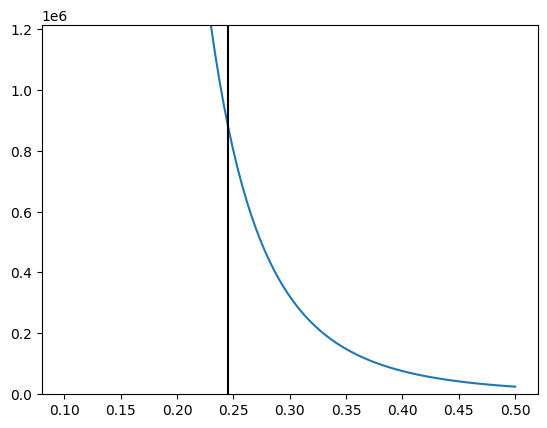

In [503]:
profile = get_density_profile()
plt.plot(np.linspace(0.1,0.5,100), profile(np.linspace(0.1,0.5,100), 1.43))
plt.ylim(0, profile(0.23, 1.43))
plt.axvline(0.245, color="k")


day: 1.17
population, limit [1.85341937 1.85272727 1.85160455 1.84978439 1.84683648 1.84206968
 1.83438168 1.82203385 1.80233402 1.77123769 1.72296769 1.64995492
 1.54373161 1.39762656 1.21144992 0.99601086 0.77284104 0.56666991
 0.39539461 0.26522585] 6.324786324786325
[ 3.41249607  3.41377084  3.41584078  3.41920191  3.42465963  3.43352175
  3.44791185  3.47127817  3.50921985  3.57082866  3.67086763  3.83330857
  4.09707639  4.52537644  5.2208401   6.35011782  8.18381271 11.16132382
 15.99613711 23.84679445]

day: 1.43
population, limit [0.61154177 0.61029274 0.60827543 0.60502803 0.59982821 0.59157263
 0.57864091 0.55880576 0.52934196 0.487596   0.43224399 0.36496875
 0.29133928 0.21945078 0.15667559 0.10698297 0.07061529 0.04549998
 0.02884275 0.01808943] 5.174825174825176
[  8.46193249   8.47925071   8.50737163   8.55303372   8.62717875
   8.74757374   8.94306832   9.26050788   9.77595885  10.61293613
  11.97200038  14.1788173   17.76219528  23.58080109  33.02891786
  48.3705501 

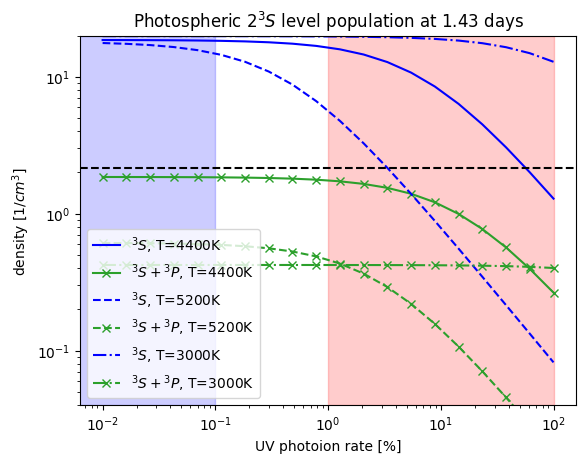

In [504]:
n23s = []
ionization_rates = np.geomspace(1e-2, 100, 20)
t_d = 1.43
vel = 0.245
for T, t_d, linestyle in zip([4400, 5200, 3000], [1.17, 1.43, 3.43], ["-", "--", "-."]):
    print()
    print("day:", t_d)
    env = Environment(T=T, t_d=t_d, photosphere_velocity=vel)
    level_pop =  env.multiplicities * env.bolzmann_factors * np.array([1,0.5])
    level_pop /= np.sum(level_pop)

    rates = []
    for ion_rate in ionization_rates:
        rates.append([
            *(level_pop * env.ionization_rates*ion_rate/100),
            *(level_pop * env.A_rates),
            *(level_pop * env.collision_k * env.n_e * 0.11951036)#*1.3)
            ])
    rates = np.array(rates)
    R = 3/4 * env.alpha * env.n_e * 5.14276e+5 #* env.n_HeII * mult

    plt.plot(ionization_rates, level_pop[0]*R/np.sum(rates[:,0::2], axis=1), alpha=1, color="b", linestyle=linestyle, label=f"$^3S$, T={T}K")
    #plt.plot(temps, 1/np.sum(rates[:,1::2], axis=1), linestyle=linestyle, label="lifetime (1s2p)")
    plt.plot(ionization_rates, level_pop[0]*R/np.sum(rates, axis=1), alpha=1, color="C2", marker="x", linestyle=linestyle, label=f"$^3S+^3P$, T={T}K")
    print("population, limit", level_pop[0]*R/np.sum(rates, axis=1), 7.4 * t_d**-1)
    print((7.4 * t_d**-1)/(level_pop[0]*R/np.sum(rates, axis=1)))

plt.axhline(7.4 * t_d**-1, color="k", linestyle="--")
plt.axvspan(-np.inf, 0.1, color="b", alpha=0.2)
plt.axvspan(1, 100, color="r", alpha=0.2)
plt.yscale("log")
plt.xscale("log")
plt.title("Photospheric $2^3S$ level population at 1.43 days")
plt.xlabel("UV photoion rate [%]")
plt.ylabel("density $[1/cm^3]$")
plt.legend()
plt.ylim(4e-2, 20)
plt.savefig("ionization_rate.png", dpi=300)

In [505]:
env.n_HeII / 5.14276e+5

0.12471633263470745

# general:
n = R / (A_ionization + A_natural + A_collision) 
where n is the number density of ortho-helium, R is the recombination rate to ortho-helium, and the A_* are the rate coefficients away from orthohelium
For the 3S+3P model, we add all the A coeficients for both the 3S and 3P level, weighted by their respective populations (according to eq. 21).
T = 4400 K (epoch 1)
n_e = 1.5 * 10^8 t_d^-3 = 5.1 * 10^7 cm^-3 (page 4)
# Recombination rate:
R = 3/4 * alpha * n_e * n_HeII
Where: 
alpha = 7.48463949e-13 (Berrington & Kingston 1987)
n_HeII =  2.86022e+5 (scraped from intercept of red line with photoshere from fig 4a)

# A_ionization 
A_ionization = 2*pi * int(sigma(nu) * BB(nu)/E(nu)) d nu (A2)
where:
sigma is the crossection for ionization (Nahar 2010).


# A_natural
Taken from NIST, respectively 1.272e-04 and 1.764e+02 s*-1 for both levels

# A_collision
q(i->1S) * n_e 
With q being calculated from eq. A1

Text(0.5, 1.0, 'Temperature from density ratio T= -ΔE/k ln(n_23P/)n_23S*g_P))')

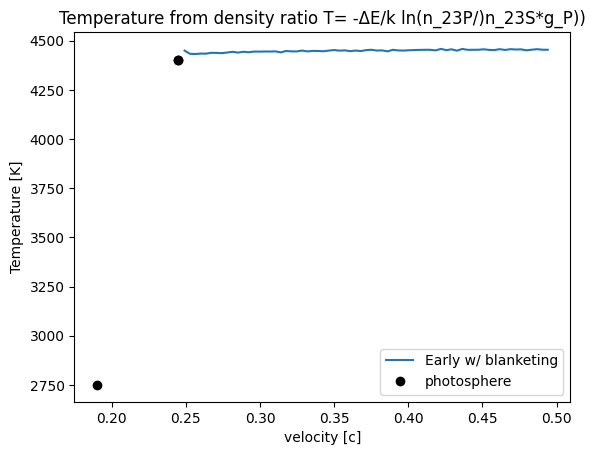

In [574]:
import astropy.units as u
import astropy.constants as const

filenames_23S = ["Early23S.csv", "Early23Swithout.csv", "Late23S.csv"]
filenames_23P = ["Early23P.csv", "Early23Pwithout.csv", "Late23P.csv"]
photsphere_velocities = [0.245, 0.245, 0.190]
photoshere_temperatures = [4400, 4400, 2750]
names = ["Early w/ blanketing", "Early without blanketing", "Late"]
for fn_23S, fn_23P, phot_v, name in zip(filenames_23S, filenames_23P, photsphere_velocities, names):
    velocity_23S, pops_23S = np.loadtxt("Tarumi_densities/" + fn_23S, unpack=True, delimiter=";")
    velocity_23P, pops_23P = np.loadtxt("Tarumi_densities/" + fn_23P, unpack=True, delimiter=";")
    interp23P = interp1d(velocity_23P, pops_23P, fill_value=np.nan, bounds_error=False)
    W = 0.5*(1-np.sqrt(1-(phot_v/velocity_23S)**2))
    nRatio = interp23P(velocity_23S)/pops_23S / W
    deltaE = (20.96 - 19.82) * u.eV
    T = -deltaE / (const.k_B * np.log(nRatio / 3))
    plt.plot(velocity_23S, T.to(u.K), label=name)
    break

plt.plot(photsphere_velocities, photoshere_temperatures, "o", color="k", label="photosphere")
plt.legend()
plt.xlabel("velocity [c]")
plt.ylabel("Temperature [K]")
plt.title("Temperature from density ratio T= -ΔE/k ln(n_23P/)n_23S*g_P))")

AttributeError: 'numpy.ndarray' object has no attribute 'index'

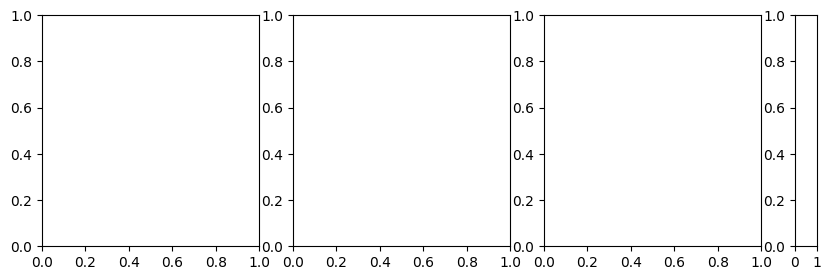

In [591]:
import transition_coefficients
from astropy.modeling.models import BlackBody
T = 4400	
transition_coefficients.calculate_alpha_coefficients(T)
states = transition_coefficients.States()
spectrum = BlackBody(T * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))
env = Environment(T=T)

# A_{i,j} = rate to state i from state j 
# A_ij * n_j = n_i

def recombination_rate_matrix(states, env, spectrum):
    recomb_rate = transition_coefficients.calculate_alpha_coefficients(T) * env.n_e
    recombination_coefficient_matrix = np.zeros((len(states.names)+2,len(states.names)+2)) # columns meaning: [state_1, state_2, ... , state_n, HeII, HeIII]
    recombination_coefficient_matrix[states.names.index("23S"), -2] = recomb_rate[0] * 0.75 # To 23S from HeII
    recombination_coefficient_matrix[states.names.index("21S"), -2] = recomb_rate[0] * 0.25 # To 21S from HeII
    recombination_coefficient_matrix[-2, -1] = recomb_rate[1] #  To HeII from HeIII
    return recombination_coefficient_matrix

def ionization_rate_matrix(states, env, spectrum):
    ionization_rate = transition_coefficients.get_ionization_rates(states, spectrum)
    ionization_coefficient_matrix = np.zeros((len(states.names)+2,len(states.names)+2)) # columns meaning: [state_1, state_2, ... , state_n, HeII, HeIII]
    ionization_coefficient_matrix[-2, :-2] = ionization_rate # To HeII from HeI
    ### Non-thermal ionization:
    
    q_dot = 1 * env.t_d**-1.3 # eV/s
    w = [600, 3000] # eV
    ionization_coefficient_matrix[-2, :-2] += q_dot/w[0] # To HeII from HeI
    ionization_coefficient_matrix[-1, -2]  += q_dot/w[1] # To HeIII from HeII
    return ionization_coefficient_matrix

def transition_rate_matrix(states, env, spectrum):
    naural_decay, spontaneous_emission_rate, stimulated_emission_rate = transition_coefficients.get_einstein_rates(states, spectrum)
    collision_coefficient = transition_coefficients.get_collision_rates(states, env.T)
    transition_coefficient_matrix = np.zeros((len(states.names)+2,len(states.names)+2)) # columns meaning: [state_1, state_2, ... , state_n, HeII, HeIII]
    transition_coefficient_matrix[:-2, :-2] = naural_decay + spontaneous_emission_rate + stimulated_emission_rate + collision_coefficient*env.n_e # From HeI to HeII
    return transition_coefficient_matrix

fig, [ax1, ax2, ax3, ax4] = plt.subplots(figsize=(10,3), ncols=4, gridspec_kw={"width_ratios":[1,1,1,0.1]})
ax1.imshow(np.log10(recombination_rate_matrix(states, env, spectrum)), vmin=-5, vmax=5)
ax2.imshow(np.log10(ionization_rate_matrix(states, env, spectrum)), vmin=-5, vmax=5)
scale = ax3.imshow(np.log10(transition_rate_matrix(states, env, spectrum)), vmin=-5, vmax=5)
ax1.title.set_text("Recombination")
ax2.title.set_text("Ionization")
ax3.title.set_text("Transition")
ax1.set_xticks(np.arange(len(states.names)+2))
ax2.set_xticks(np.arange(len(states.names)+2))
ax3.set_xticks(np.arange(len(states.names)+2))
ax1.set_yticks(np.arange(len(states.names)+2))
ax2.set_yticks(np.arange(len(states.names)+2))
ax3.set_yticks(np.arange(len(states.names)+2))
ax1.set_yticklabels(states.names + ["HeII", "HeIII"])
ax2.set_yticklabels(states.names + ["HeII", "HeIII"])
ax3.set_yticklabels(states.names + ["HeII", "HeIII"])
ax1.set_xticklabels(states.names + ["HeII", "HeIII"], rotation=90)
ax2.set_xticklabels(states.names + ["HeII", "HeIII"], rotation=90)
ax3.set_xticklabels(states.names + ["HeII", "HeIII"], rotation=90)
ax2.set_xlabel("From")
ax1.set_ylabel("To")
# add colorbar to ax4
cbar = fig.colorbar(scale, cax=ax4)
plt.tight_layout()



In [514]:

T = 2000	
transition_coefficients.calculate_alpha_coefficients(T)
states = transition_coefficients.States()
spectrum = BlackBody(T * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))
env = Environment(T=T)

rate_matrix = recombination_rate_matrix(states, env, spectrum) + ionization_rate_matrix(states, env, spectrum) + transition_rate_matrix(states, env, spectrum)
#rate_matrix /= np.sum(rate_matrix, axis=0)
np.fill_diagonal(rate_matrix, -np.sum(rate_matrix, axis=0))


#scipy.linalg.solve(rate_matrix, np.zeros(len(states.names)+2))

#import scipy.optimize
# A_{i,j} = rate to state i from state j 
def state_error(n):
    n = stable_softmax(n)
    loss = rate_matrix @ n
    return loss
res = scipy.optimize.root(state_error, np.zeros(len(states.names)+2))#, bounds=[(-np.inf,60)]*(len(states.names)+2))#, constraints={"type":"eq", "fun":lambda n: np.sum(np.exp(n))-1})
print(res.x)
#scipy.linalg.eig(rate_matrix, left=True, right=False)
#plt.plot(states.names + ["HeII", "HeIII"], np.exp(res.x))

11S
23S
21S
23P
21P
33S
31S
33P
33D
31D
31P
['11S', '23S', '21S', '23P', '21P', '33S', '31S', '33P', '33D', '31D', '31P']
0.327
12320.0
15100.0
[  62.35498371   28.98103474   29.47413155   29.52026289   26.44923814
   29.3658456    30.30530065   29.04035653   27.01587312   29.78495742
   25.67840201   19.12077754 -222.56025025]


/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [515]:
transition_coefficients.States()

States(names=['11S', '23S', '21S', '23P', '21P', '33S', '31S', '33P', '33D', '31D', '31P'], multiplicities=array([ 1,  3,  1,  9,  3,  3,  1,  9, 15,  5,  3]), energies=<Quantity [ 0.        , 19.81961452, 20.61577482, 20.96408689, 21.21802271,
           22.71846642, 22.92031736, 23.00707315, 23.07365071, 23.0740748 ,
           23.08701853] eV>)

/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


11S
23S
21S
23P
21P
33S
31S
33P
33D
31D
31P
['11S', '23S', '21S', '23P', '21P', '33S', '31S', '33P', '33D', '31D', '31P']
0.327
12320.0
15100.0
11S 0.017318721808871448
23S 2.1732392812680372e-07
21S 4.2603224657361616e-12
23P 1.7510820474261006e-08
21P 9.955904993358627e-15
33S 2.3759899180291907e-09
31S 2.5653120927642955e-15
33P 3.4345582071506813e-10
33D 2.477140031390156e-10
31D 1.4159250689673156e-13
31P 3.251159132319142e-16
HeII 0.47225837369218976
HeIII 0.5104226668480993


/home/rasmus/.local/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


11S
23S
21S
23P
21P
33S
31S
33P
33D
31D
31P
['11S', '23S', '21S', '23P', '21P', '33S', '31S', '33P', '33D', '31D', '31P']
0.327
12320.0
15100.0
11S 0.017318721807005926
23S 2.1732392810479851e-07
21S 4.260322465288454e-12
23P 1.7510820472487944e-08
21P 9.955904992340932e-15
33S 2.3759899177886102e-09
31S 2.5653120925025377e-15
33P 3.434558206802915e-10
33D 2.477140031139333e-10
31D 1.415925068823943e-13
31P 3.2511591319783084e-16
HeII 0.4722583736425017
HeIII 0.5104226668006555


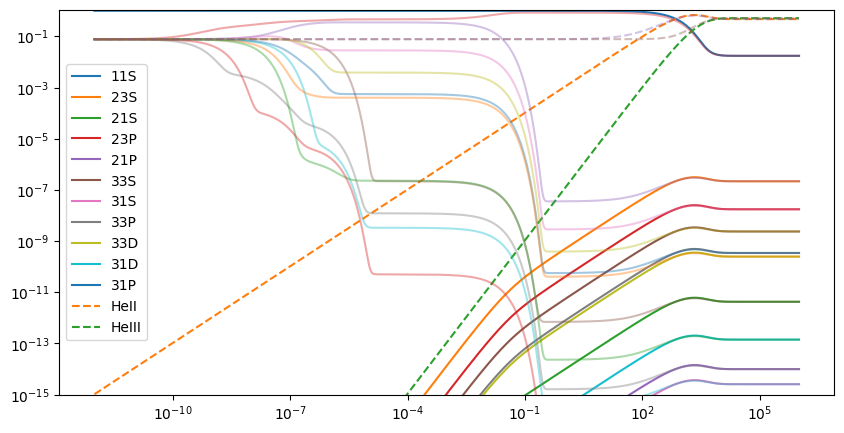

In [542]:
from scipy.integrate import solve_ivp

for states in [transition_coefficients.States()]:#, transition_coefficients.States(['11S', '23S', '21S', '21P'], np.array([1,3,1, 3]), np.array([ 0.        , 19.81961452, 20.61577482, 21.21802271])*u.eV), 
               #transition_coefficients.States(['11S', '23S', '21S'], np.array([1,3,1]), np.array([ 0.        , 19.81961452, 20.61577482])*u.eV)]:
    T = 4400	
    transition_coefficients.calculate_alpha_coefficients(T)
    #states = transition_coefficients.States()
    #states = transition_coefficients.States(['11S', '23S', '21S'], np.array([1,3,1]), np.array([ 0.        , 19.81961452, 20.61577482])*u.eV)
    spectrum = BlackBody(T * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))
    env = Environment(T=T)
    spectrum_killed = BlackBody(1 * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))

    rate_matrix = recombination_rate_matrix(states, env, spectrum) + ionization_rate_matrix(states, env, spectrum_killed) + transition_rate_matrix(states, env, spectrum)
    #rate_matrix /= np.sum(rate_matrix, axis=0)
    rate_save = rate_matrix.copy()
    np.fill_diagonal(rate_matrix, -np.sum(rate_matrix, axis=0))
    initial = np.zeros(len(states.names)+2)
    initial[0] = 1
    solution = solve_ivp(lambda t, n: rate_matrix@n, (0, 1000000), 
                        initial, 
                        t_eval=np.geomspace(1e-12,1000000, 1000), 
                        method="LSODA",  rtol=1e-6, atol=1e-40)
    plt.figure(figsize=(10,5))
    plt.plot(solution.t, solution.y.T[:, :-2], label = states.names);
    plt.plot(solution.t, solution.y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"]);
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-15, 1.1)
    plt.legend()
    for name, amount in zip(states.names + ["HeII", "HeIII"], solution.y.T[-1]):
        print(name, amount)



    T = 4400	
    transition_coefficients.calculate_alpha_coefficients(T)
    #states = transition_coefficients.States()
    #states = transition_coefficients.States(['11S', '23S', '21S'], np.array([1,3,1]), np.array([ 0.        , 19.81961452, 20.61577482])*u.eV)
    spectrum = BlackBody(T * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))
    env = Environment(T=T)
    spectrum_killed = BlackBody(1 * u.K, scale=1*u.Unit("erg/(Hz s sr cm2)"))

    rate_matrix = recombination_rate_matrix(states, env, spectrum) + ionization_rate_matrix(states, env, spectrum_killed) + transition_rate_matrix(states, env, spectrum)
    #rate_matrix /= np.sum(rate_matrix, axis=0)
    rate_save = rate_matrix.copy()
    np.fill_diagonal(rate_matrix, -np.sum(rate_matrix, axis=0))
    initial = np.zeros(len(states.names)+2)
    initial[0] = 1
    solution = solve_ivp(lambda t, n: rate_matrix@n, (0, 1000000), 
                        np.ones(len(rate_matrix))/len(rate_matrix), 
                        t_eval=np.geomspace(1e-12,1000000, 1000), 
                        method="LSODA",  rtol=1e-6, atol=1e-40)
    plt.plot(solution.t, solution.y.T[:, :-2], label = states.names, alpha=0.4);
    plt.plot(solution.t, solution.y.T[:, -2:], linestyle="--", label  = ["HeII", "HeIII"], alpha=0.4);
    plt.yscale("log")
    plt.xscale("log")
    plt.ylim(1e-15, 1.1)
    for name, amount in zip(states.names + ["HeII", "HeIII"], solution.y.T[-1]):
        print(name, amount)


/tmp/ipykernel_106577/1760703283.py:10: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(total_fluxes)+7, 0, 10)
/tmp/ipykernel_106577/1760703283.py:10: RuntimeWarning: invalid value encountered in log10
  widths = np.clip(np.log10(total_fluxes)+7, 0, 10)


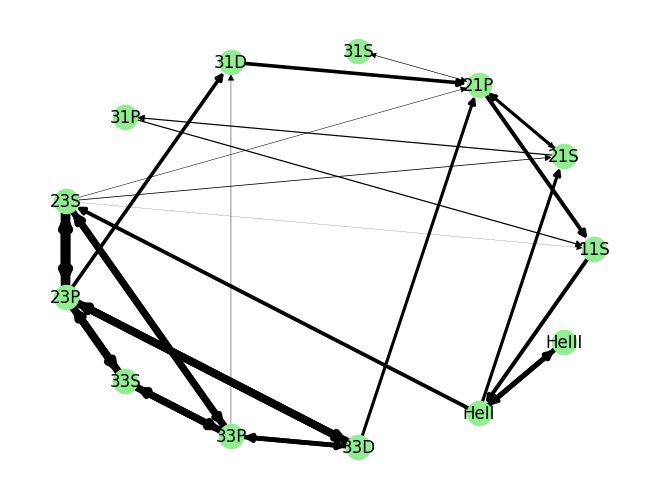

In [517]:
import networkx as nx

# A_{i,j} = rate to state i from state j 

total_fluxes = (rate_save * solution.y.T[-1][None,:]).T#[Non,:]
total_fluxes = total_fluxes / np.max(total_fluxes)
# give nodes the names states.names + ["HeII", "HeIII"]
order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]

widths = np.clip(np.log10(total_fluxes)+7, 0, 10)
G = nx.DiGraph(widths[order, :][:, order])
labels = {i:name for i, name in enumerate(np.array(states.names + ["HeII", "HeIII"])[order])}
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.circular_layout(G)
nx.draw(G, pos,
        width=list(weights),
        with_labels=True,
        labels=labels,
        node_color='lightgreen')
#plt.plot(states.names + ["HeII", "HeIII"], -np.diag(rate_matrix))
#plt.yscale("log")
#plt.xlabel("State")
#nx.draw_circular(G, with_labels=True, labels=labels, width=list(widths))

In [592]:
import networkx as nx

# A_{i,j} = rate to state i from state j 

total_fluxes = (rate_save * solution.y.T[-1][None,:]).T#[Non,:]
total_fluxes = total_fluxes / np.max(total_fluxes)
# give nodes the names states.names + ["HeII", "HeIII"]
order= [0,2,4,6,9, 10,1, 3, 5, 7, 8, 11, 12]

widths = np.clip(np.log10(total_fluxes)+7, 0, 10)
G = nx.DiGraph(widths[order, :][:, order])
labels = {i:name for i, name in enumerate(np.array(states.names + ["HeII", "HeIII"])[order])}
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.circular_layout(G)
nx.draw(G, pos,
        width=list(weights),
        with_labels=True,
        labels=labels,
        node_color='lightgreen')
#plt.plot(states.names + ["HeII", "HeIII"], -np.diag(rate_matrix))
#plt.yscale("log")
#plt.xlabel("State")
#nx.draw_circular(G, with_labels=True, labels=labels, width=list(widths))

/tmp/ipykernel_106577/1760703283.py:10: RuntimeWarning: divide by zero encountered in log10
  widths = np.clip(np.log10(total_fluxes)+7, 0, 10)
/tmp/ipykernel_106577/1760703283.py:10: RuntimeWarning: invalid value encountered in log10
  widths = np.clip(np.log10(total_fluxes)+7, 0, 10)


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U5')) -> None

In [553]:
actual/ expected

<Quantity [ 1.04980012,  0.57685636, 23.99941222,  2.47558006,  1.27692714]>

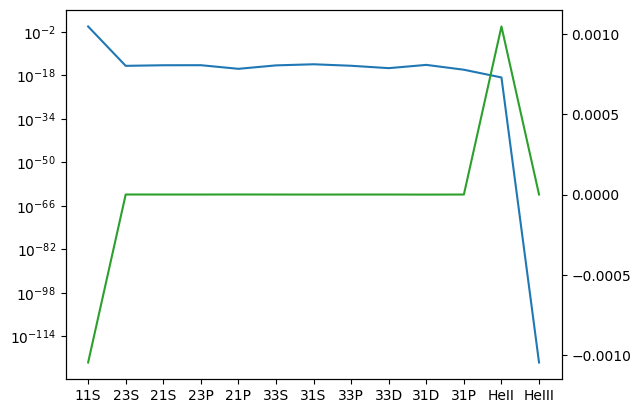

In [367]:
n = stable_softmax(res.x)

plt.plot(states.names + ["HeII", "HeIII"], n)
plt.yscale("log")
#plt.ylim(1e-12, 1)
# plot error on second y axis
plt.gca().twinx().plot(states.names + ["HeII", "HeIII"], rate_matrix @ n, c="C2")

/tmp/ipykernel_106577/594295366.py:3: RuntimeWarning: divide by zero encountered in log10
  widths = np.maximum((np.log10((rate_matrix))+5)/5, 0)
/tmp/ipykernel_106577/594295366.py:3: RuntimeWarning: invalid value encountered in log10
  widths = np.maximum((np.log10((rate_matrix))+5)/5, 0)


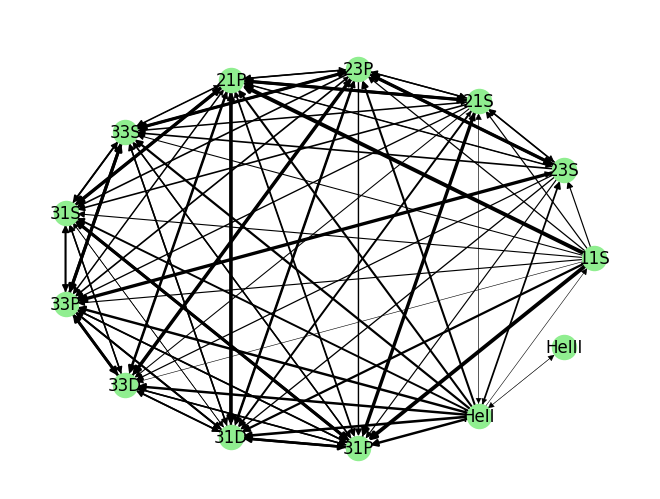

In [364]:
import networkx as nx
# give nodes the names states.names + ["HeII", "HeIII"]
widths = np.maximum((np.log10((rate_matrix))+5)/5, 0)
G = nx.DiGraph(widths)
labels = {i:name for i, name in enumerate(states.names + ["HeII", "HeIII"])}
weights = nx.get_edge_attributes(G,'weight').values()

pos = nx.circular_layout(G)
nx.draw(G, pos, 
        width=list(weights),
        with_labels=True,
        labels=labels,
        node_color='lightgreen')
#plt.plot(states.names + ["HeII", "HeIII"], -np.diag(rate_matrix))
#plt.yscale("log")
#plt.xlabel("State")
#nx.draw_circular(G, with_labels=True, labels=labels, width=list(widths))

In [497]:
import pandas 
get_n = lambda n, l, count: (int(n)-1)*2 if count else (int(n)-1)
nist_table = pandas.read_csv("A_rates_NIST.csv")
def get_state_name(config_series, term_series):
    n = config_series.str.findall("([\d+]+)([spdf])(2?)").apply(lambda x: str(1+sum([get_n(*nlm) for nlm in x])))
    term = term_series.str.strip("=\"*")
    return n+term

i_state = get_state_name(nist_table["conf_i"], nist_table["term_i"])
j_state = get_state_name(nist_table["conf_k"], nist_table["term_k"])
states = ["11S", "23S", "21S", "23P", "21P", "33S", "31S", "33P", "33D", "31D", "31P"]
A_coefficients = np.zeros((len(states), len(states)))

for state_i in states:
    print(state_i)
    selection = (i_state == state_i) & (j_state.isin(states)) & (nist_table["Aki(s^-1)"] != '=""')
    selected_A = nist_table[selection]["Aki(s^-1)"].str.strip("=\"*")
    for state_j, A in zip(j_state[selection], selected_A):
        A_coefficients[states.index(state_i),states.index(state_j)] = float(A)
"""
# F. Drake 1969
drake_coeff = {"11S": {"21S": 5.13e1}}#, "23S": 4.02e-9}}
for state_i, subtable in drake_coeff.items():
    if state_i not in states:
        continue
    for state_j, coeff in subtable.items():
        if state_j not in states:
            continue
        A_coefficients[states.index(state_i),states.index(state_j)] = coeff
"""

11S
23S
21S
23P
21P
33S
31S
33P
33D
31D
31P


'\n# F. Drake 1969\ndrake_coeff = {"11S": {"21S": 5.13e1}}#, "23S": 4.02e-9}}\nfor state_i, subtable in drake_coeff.items():\n    if state_i not in states:\n        continue\n    for state_j, coeff in subtable.items():\n        if state_j not in states:\n            continue\n        A_coefficients[states.index(state_i),states.index(state_j)] = coeff\n'

/tmp/ipykernel_695/895936851.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(A_coefficients))


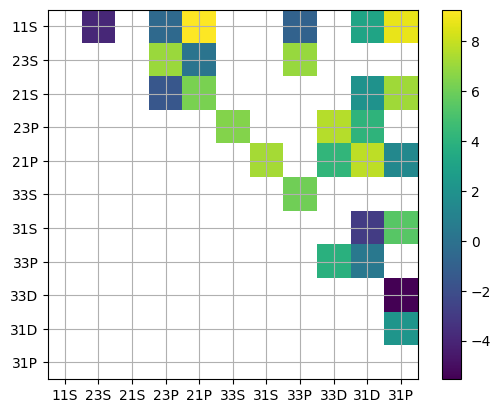

In [499]:
plt.imshow(np.log10(A_coefficients))
plt.gca().set_xticks(np.arange(len(states)))
plt.gca().set_yticks(np.arange(len(states)))
plt.gca().set_xticklabels(states)
plt.gca().set_yticklabels(states)
plt.grid()
plt.colorbar()

In [556]:
import re
with open("Photoionization/he1.txt") as f:
    text = f.read().splitlines()
    species = dict()
 # cut off header
    for row in text[46:]:
        splitted = row.split()
        if len(splitted) == 4:
            energies, cross = [], []
            species[splitted[3] + splitted[0] + "SPDFABCD"[int(splitted[1])]] = (energies, cross)
            print(splitted[3] + splitted[0] + "SPDFABCD"[int(splitted[1])], row)
        elif len(splitted) == 2 and "E" in splitted[0]:
            energies.append(float(splitted[0]))
            cross.append(float(splitted[1]))


11S     1    0    0    1
21S     1    0    0    2
31S     1    0    0    3
41S     1    0    0    4
51S     1    0    0    5
61S     1    0    0    6
71S     1    0    0    7
81S     1    0    0    8
91S     1    0    0    9
101S     1    0    0   10
11P     1    1    1    1
21P     1    1    1    2
31P     1    1    1    3
41P     1    1    1    4
51P     1    1    1    5
61P     1    1    1    6
71P     1    1    1    7
81P     1    1    1    8
11D     1    2    0    1
21D     1    2    0    2
31D     1    2    0    3
41D     1    2    0    4
51D     1    2    0    5
61D     1    2    0    6
71D     1    2    0    7
81D     1    2    0    8
11F     1    3    1    1
21F     1    3    1    2
31F     1    3    1    3
41F     1    3    1    4
51F     1    3    1    5
61F     1    3    1    6
71F     1    3    1    7
11A     1    4    0    1
21A     1    4    0    2
31A     1    4    0    3
41A     1    4    0    4
51A     1    4    0    5
61A     1    4    0    6
11B     1    5    1    1

In [628]:
import transition_coefficients
import astropy.units as u
import astropy.constants as consts

# calculates the naural decay, spontaneous emission rate and stimulated emission rate
def get_einstein_rates(states, energies, multiplicities, spectrum):
    A = transition_coefficients.get_A_rates(states) * u.s**-1
    E_diff = np.array(energies) - np.array(energies)[:,np.newaxis] + 1e-10
    nu = (E_diff * u.eV).to(u.Hz, equivalencies=u.spectral())
    const = consts.c**2 / (2 * consts.h * nu**3)
    g_ratio = multiplicities[:,np.newaxis] / multiplicities
    rho = 2 * np.pi * u.sr * spectrum(nu)
    return A.value, (A * const * rho).to("1/s").value, (A * const * rho * g_ratio).T.to("1/s").value

spectrum = BlackBody(4400*u.K, scale=1*u.Unit("erg/(s Hz sr cm2)"))
print(get_einstein_rates(["11S", "23S", "23P"], [0, 19.82, 20.96], np.array([1, 3, 9]), spectrum))


11S
23S
23P
(array([[0.0000e+00, 1.2720e-04, 3.2700e-01],
       [0.0000e+00, 0.0000e+00, 1.0216e+07],
       [0.0000e+00, 0.0000e+00, 0.0000e+00]]), array([[ 0.00000000e+00,  1.58765839e-26,  2.01863125e-24],
       [-0.00000000e+00,  0.00000000e+00,  3.33986469e+06],
       [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00]]), array([[ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [ 5.29219463e-27,  0.00000000e+00, -0.00000000e+00],
       [ 2.24292361e-25,  1.11328823e+06,  0.00000000e+00]]))


In [618]:
(1.0216e+07+1.37148152e+07)/4.57160507e+06

5.2346637195412855

Text(0, 0.5, 'Lifetime [s]')

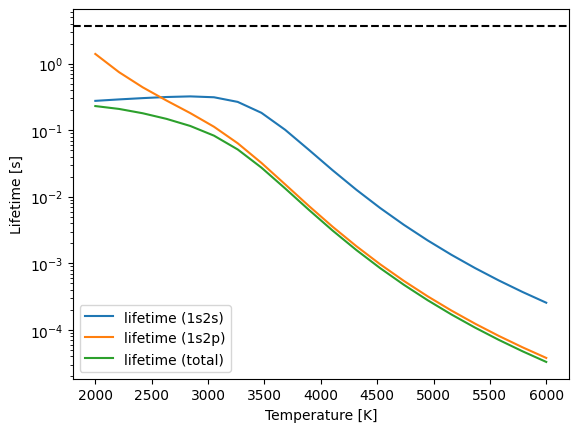

In [384]:
temps = np.linspace(2000,6000, 20)
rates = []
for temp in temps:
    env = Environment(T=temp, t_d=2)
    level_pop =  env.multiplicities * env.bolzmann_factors
    rates.append([
        #recombination_rate(level_pop, env), 
        *(level_pop * env.ionization_rates),
        *(level_pop * env.A_rates),
        *(level_pop * env.collision_k * env.n_e)
        ])
rates = np.array(rates)
plt.plot(temps, 1/np.sum(rates[:,0::2], axis=1), label="lifetime (1s2s)")
plt.plot(temps, 1/np.sum(rates[:,1::2], axis=1), label="lifetime (1s2p)")
plt.plot(temps, 1/np.sum(rates, axis=1), label="lifetime (total)")
rho_crit = 7.4 * env.t_d**-1
R = 3/4 * env.alpha * env.n_e * env.n_HeII
plt.axhline(rho_crit/R, color="k", linestyle="--")
plt.legend()
plt.yscale("log")
plt.xlabel("Temperature [K]")
plt.ylabel("Lifetime [s]")

In [375]:
3/4 * env.alpha * env.n_e * env.n_HeII

7.503890129466293

In [251]:
env.n_e, env.n_HeII

(51295958.18627068, 4.594890904047518e+23)

# Ionization flux diagnostics

TypeError: Environment.calculate_number_densities() missing 3 required positional arguments: 't_d', 'M_ejecta', and 'Y_He'

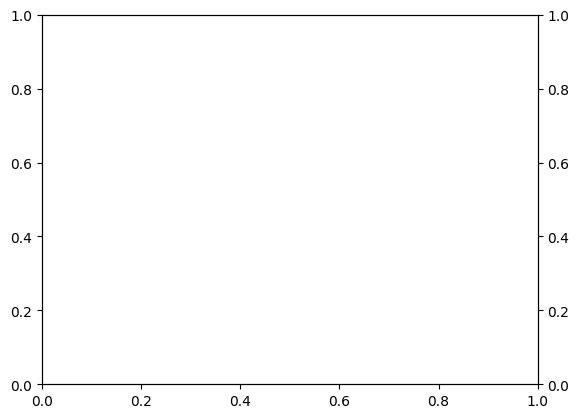

In [182]:
import astropy.units as u
import astropy.constants as const
from astropy.modeling.physical_models import BlackBody
import scipy.integrate 
# convenience function for integrating with units
cumtrapz = lambda x,y: scipy.integrate.cumulative_trapezoid(x=x.value, y=y.value, initial=0)*y.unit*x.unit  


for day, T in zip([1.43, 2.42, 3.41, 4.40], [4000, 3150, 2750, 2600]):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    env = Environment(t_d=day, T=T)
    R_phot = (1.43 * u.day * (0.4 * const.c)).cgs
    R_line = (1.43 * u.day * (0.4 * const.c)).cgs
    bb = BlackBody(T * u.K, scale=1*u.Unit("erg/(nm s sr cm2)")) 
    states=["1s2s", "1s2p"]

    wls = []
    ion_rates = []
    for state in states:
        E, sigma = np.fliplr(np.loadtxt(state + "_ionization.csv", unpack=True))
        E = (E * u.Ry).cgs
        sigma = (sigma * u.Mbarn).cgs
        freq = E.to(u.Hz, equivalencies=u.spectral())
        wl = freq.to(u.nm, equivalencies=u.spectral())

        # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf page 3
        surface_luminosity = 4 * np.pi**2 * u.sr**2 * R_phot ** 2 * bb(wl)  # total emitted energy flux per wavelength times cone size
        energy_flux = surface_luminosity / (4 * np.pi * u.sr * R_line ** 2) # energy flux per area per wavelength at the line forming region
        # could also just write the above as energy_flux = bb(freq) * (pi * u.sr) * (R_phot / R_line) ** 2

        # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf page 1
        number_density = 4 * np.pi * energy_flux / (const.c.cgs * const.h.cgs * freq) # photons per second per wavelength per volume (per frequency/times time?)
        ion_rate = const.c.cgs * sigma * number_density # photon ionization rate per wavelength per second
        ion_rate = ion_rate.to(1/(u.s*u.nm))
        cum_ion_rate = cumtrapz(x=wl, y=ion_rate)
        wls.append(wl)
        ion_rates.append(ion_rate)
        ax1.plot(wl, ion_rate, label=rf"{state}, $\tau={(1/cum_ion_rate[-1]).si:.3}$")
        ax1.set_xlabel(f"photon wl [{wl.unit}]")
        ax1.set_ylabel(f"ionization rate [{ion_rate.unit}]")
    
        #
        ax2.plot(wl, cum_ion_rate/cum_ion_rate[-1], alpha=0.5, linestyle="--")

        ########################
        ### TESTED: this is the same as the above, but given in the article, with geometric factor np.pi**2*4 ~ 40
        ### For now just use the above, since it's more general

        # ionization_flux_article = np.pi**2*4*u.sr * sigma * bb(wl)/E # photon ionization rate per frequency per second
        # ionization_rate = np.trapz(x=wl, y=ionization_flux_article)
        # print(ionization_rate)
        ########################

    wl_grid = np.linspace(min(map(min, wls)), max(map(max, wls)), 100)
    total_ion_rates = np.zeros(len(wl_grid)) * ion_rates[0].unit
    for wl, ion_rate, bolz, mult in zip(wls, ion_rates, env.bolzmann_factors, env.multiplicities):
        total_ion_rates += np.interp(wl_grid, wl, ion_rate) * bolz * mult / sum(env.bolzmann_factors * env.multiplicities)

    cum_total_ion_rate = cumtrapz(x=wl_grid, y=total_ion_rates)
    ax1.plot(wl_grid, total_ion_rates, label=rf"total, $\tau={(1/cum_total_ion_rate[-1]).si:.3}$")
    ax2.plot(wl_grid, cum_total_ion_rate/cum_total_ion_rate[-1], alpha=0.5, linestyle="--")

    # http://www.astro.yale.edu/vdbosch/astro320_summary24.pdf
    plt.title(f"Photoionization lifetime at {T=}")
    plt.xlim(200, 350)
    ax1.set_ylim(1e-5, 100)
    ax1.set_yscale("log")
    ax1.legend()
    plt.xlabel("photon wl [nm]")
    #plt.ylabel("Photoionization Cross section (Mb)")
    ax1.set_ylabel("Ionization rate per ion per frequency (# / (s * nm))")
    ax2.set_ylabel("Cumulative ionization photons fraction")
    #plt.xlim(3, 6)
    plt.show()


# Check of density calculation

1.1924922778585649e-47 cm3 solMass / g 0.002 4.0 u
1.1924922778585649e-47 cm3 solMass / g 0.01 87.62 u


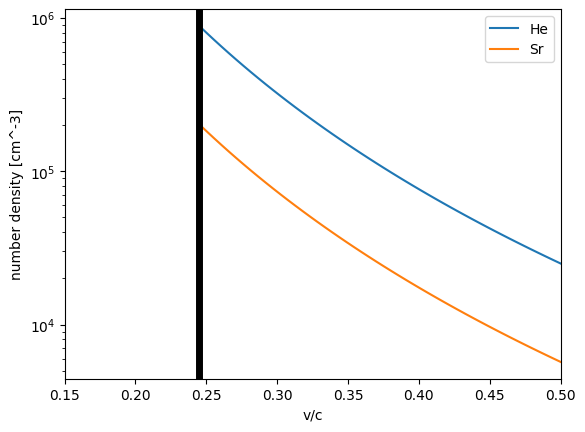

In [234]:
# calculate density profile at t=1 day

rho = lambda v,t, rho0, p=5, v_0=0.2, t_0=1 : rho0 * (v/v_0)**-p * (t/t_0)**-3
# M = int dM/dV*dV/dr*dr/dv wrt dv
# r = 1 day * v
# M = int rho(v)*dV/dr*dr/dv wrt dv
# output in g/c
def dMdv(v, t):
    v = v*const.c
    t = t*u.day
    dr_dv = 1*u.day
    r = 1*u.day * v
    dV_dr = 4*np.pi*r**2
    dM_dV = rho(v, t, 1*u.g/u.cm**3, v_0=0.2*const.c, t_0=1*u.day)
    return (dM_dV.cgs * dV_dr.cgs * dr_dv.cgs * const.c).cgs.value
def get_density_profile(M_ej = 0.04 * u.M_sun, atomic_mass=4*u.u, mass_fraction=0.002):
    # we calculate the density profile at t=1 day, and normalize it to 0.04 solar mass
    rho_0 =  M_ej / (scipy.integrate.quad(dMdv, 0.1, 0.5, args=1)[0] * u.g/u.cm**3)
    number_density_0 = (rho_0 * mass_fraction / atomic_mass).cgs.value
    print(rho_0, mass_fraction, atomic_mass)
    return lambda v, t: rho(v, t, number_density_0)
Y_He = 0.002 # fraction by mass (sec 4.1)
m_He = 4*u.u # mass of He
Y_Sr = 0.01 # fraction by mass (sec 4.1)
m_Sr = 87.62 *u.u # mass of He
x_range = np.linspace(0.245, 0.5)
density_profile = get_density_profile(atomic_mass=m_He, mass_fraction=Y_He)
plt.semilogy(x_range, density_profile(x_range, 1.43), label="He")
density_profile = get_density_profile(atomic_mass=m_Sr, mass_fraction=Y_Sr)
plt.semilogy(x_range, density_profile(x_range, 1.43), label="Sr")
#plt.ylim(1e-6, 1e6)
plt.xlim(0.15, 0.5)
plt.axvline(x=0.245, c="k", linewidth=5)
plt.xlabel("v/c")
plt.ylabel("number density [cm^-3]")
plt.legend()
# make ticks on every power of 10 on the y axis
plt.gca().yaxis.set_major_locator(plt.LogLocator(numticks=10))

In [180]:
import sympy as sp

rho_0, v_0, v, t, t_0, r, c = sp.symbols("rho_0, v_0, v, t, t_0, r, c")
v = r / (c * t)
rho = rho_0 * (v/v_0)**-5 * (t/t_0)**-3

M_tot = sp.Integral(rho * 4 * sp.pi * r**2, (r, 0.1*t/c, 0.5*t/c)).doit()
rho_0 = sp.solve(sp.Eq(M_tot, 0.04), rho_0)[0]
rho_0 = rho_0.evalf(subs={v_0:0.1, t_0:1, t:1.43, c:1})
(rho_0 * u.M_sun/(u.s * scipy.constants.c * u.m/u.s)**3 * Y_He / (4*u.u)).cgs
#M_tot#rho.evalf(subs={})

<Quantity 1.47357959e+23 1 / cm3>

In [197]:
(0.04 * u.M_sun * Y_He / (0.3 * const.c * 1.43 * u.day)**3 / (4*u.u)).cgs

<Quantity 17454668.12625643 1 / cm3>

In [195]:
17454668 / 30086805

0.5801436210990166

In [552]:
wl_range = np.linspace(200, 350, 100) * u.nm
E, sigma = np.fliplr(np.loadtxt(state + "_ionization.csv", unpack=True))
E = E * u.Ry
sigma = (sigma * u.Mbarn).cgs
freq = E.to(u.Hz, equivalencies=u.spectral())
wl = freq.to(u.nm, equivalencies=u.spectral())
np.interp(wl_range, wl, sigma)

<Quantity [3.18068501e-18, 3.24970974e-18, 3.31988509e-18, 3.39024652e-18,
           3.46060794e-18, 3.53196657e-18, 3.60361525e-18, 3.67526392e-18,
           3.75786110e-18, 3.84970649e-18, 3.94155187e-18, 4.03086857e-18,
           4.10611754e-18, 4.18136651e-18, 4.25661548e-18, 4.33252439e-18,
           4.40888485e-18, 4.48524530e-18, 4.56160576e-18, 4.65602973e-18,
           4.75355945e-18, 4.85108918e-18, 4.94861890e-18, 5.02971339e-18,
           5.10931439e-18, 5.18891540e-18, 5.26851640e-18, 5.38119716e-18,
           5.50386355e-18, 5.62652993e-18, 5.74919632e-18, 5.86523594e-18,
           5.97090991e-18, 6.07658389e-18, 6.18225786e-18, 6.28793184e-18,
           6.39553811e-18, 6.50374570e-18, 6.61195329e-18, 6.72016088e-18,
           6.82836847e-18, 6.91891633e-18, 7.00669099e-18, 7.09446565e-18,
           7.18224031e-18, 7.27001496e-18, 7.38903189e-18, 7.52341704e-18,
           7.65780219e-18, 7.79218734e-18, 7.92657248e-18, 8.06167981e-18,
           8.20078218e-18

1733051805.9144266 erg / (s cm2)
[0.00000000e+00 5.97287591e-36 1.48277899e-35 2.79549286e-35
 4.74148272e-35 7.62615005e-35 1.19021280e-34 1.82402360e-34
 2.76346166e-34 4.15585171e-34 6.21951001e-34 9.27794099e-34
 1.38105001e-33 2.05274493e-33 3.04811441e-33 4.52307403e-33
 6.70861717e-33 9.94695351e-33 1.47450362e-32 2.18538407e-32
 3.23857809e-32 4.79885981e-32 7.11028779e-32 1.05343393e-31
 1.56063793e-31 2.31192753e-31 3.42472022e-31 5.07289481e-31
 7.51393031e-31 1.11290840e-30 1.64828709e-30 2.44111132e-30
 3.61512762e-30 5.35353906e-30 7.92756015e-30 1.17386798e-29
 1.73812095e-29 2.57348500e-29 3.81016747e-29 5.64088347e-29
 8.35085013e-29 1.23621669e-28 1.82994785e-28 2.70871225e-28
 4.00928495e-28 5.93404327e-28 8.78241727e-28 1.29974106e-27
 1.92344095e-27 2.84629531e-27 4.21172464e-27 6.23187486e-27
 9.22053345e-27 1.36418028e-26 2.01820698e-26 2.98564163e-26
 4.41659433e-26 6.53303548e-26 9.66317869e-26 1.42923059e-25
 2.11378935e-25 3.12606514e-25 4.62286341e-25 6.8359

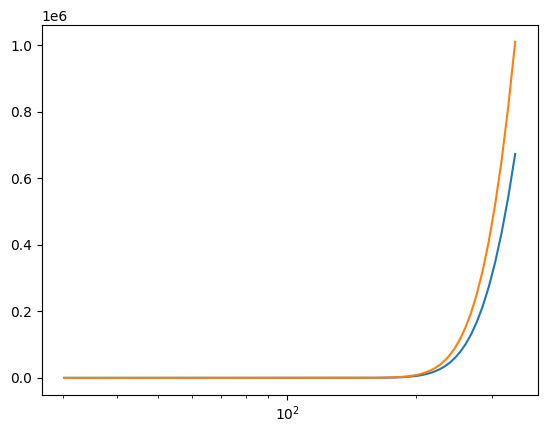

In [595]:
# declare a blackbody as a function of wavelength
T = 4000 * u.K
bb = BlackBody(T, scale=1*u.Unit("erg/(nm s sr cm2)")) 
cumtrapz = lambda x,y: scipy.integrate.cumulative_trapezoid(x=x.value, y=y.value, initial=0)*y.unit*x.unit
plt.plot(wl, bb(wl))
bb = BlackBody(T, scale=1.5*u.Unit("erg/(nm s sr cm2)")) 
plt.plot(wl, bb(wl))
print(np.trapz(x=wl, y=bb(wl))*4*np.pi**2*u.sr)
print(cumtrapz(x=wl, y=bb(wl))*4*np.pi**2*u.sr)
print(wl.unit, bb(wl).unit)
print(bb.bolometric_flux)
bb = BlackBody(T) 
print(cumtrapz(x=wl.to(u.Hz, equivalencies=u.spectral()), y=bb(wl))[-1])
plt.xscale("log")

In [431]:
sum(env.bolzmann_factors * env.multiplicities)

1.018464114768631

In [428]:
env.bolzmann_factors, env.multiplicities

(array([1.       , 0.0061547]), array([1, 3]))

In [406]:
cum_trap

array([8.39351230e-31, 6.32284516e-27, 1.38913698e-23, 1.04273125e-20,
       2.97572197e-18, 4.30460175e-16, 3.39628971e-14, 1.62471659e-12,
       5.29296203e-11, 1.18031463e-09, 1.98713361e-08, 2.57477785e-07,
       2.66768839e-06, 2.26563084e-05, 1.63823860e-04, 1.02214448e-03,
       5.54527309e-03, 2.66870313e-02, 1.14492111e-01, 4.52250396e-01,
       1.63099604e+00, 5.44025820e+00, 1.67394352e+01, 4.85712542e+01,
       1.33110652e+02, 3.44516363e+02, 8.45423771e+02, 1.98115499e+03,
       4.43011912e+03, 9.58072795e+03, 1.99036651e+04, 3.98401981e+04,
       7.75609682e+04, 1.45935715e+05, 2.67383380e+05, 4.78179077e+05,
       8.34657221e+05, 1.42473531e+06, 2.37905042e+06, 3.88190596e+06,
       6.20431847e+06, 9.75216168e+06, 1.51338091e+07, 2.31660563e+07,
       3.48372266e+07, 5.14815392e+07, 7.50219829e+07, 1.08213798e+08,
       1.54317148e+08, 2.17454112e+08, 3.03013547e+08, 4.17168620e+08,
       5.68719869e+08, 7.69143847e+08, 1.03014052e+09, 1.36569879e+09,
      

In [381]:
np.interp(wl_grid.cgs, wl.cgs, ion_rate.cgs)

<Quantity [6.55292504e+08, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38, 5.59309790e-38, 5.59309790e-38, 5.59309790e-38,
           5.59309790e-38

In [332]:
wl_grid = np.linspace(min(map(min, wls)), max(map(max, wls)), 100) 
wl_grid

<Quantity [ 30.17013042,  33.30606519,  36.44199995,  39.57793471,
            42.71386948,  45.84980424,  48.98573901,  52.12167377,
            55.25760853,  58.3935433 ,  61.52947806,  64.66541283,
            67.80134759,  70.93728235,  74.07321712,  77.20915188,
            80.34508665,  83.48102141,  86.61695617,  89.75289094,
            92.8888257 ,  96.02476047,  99.16069523, 102.29663   ,
           105.43256476, 108.56849952, 111.70443429, 114.84036905,
           117.97630382, 121.11223858, 124.24817334, 127.38410811,
           130.52004287, 133.65597764, 136.7919124 , 139.92784716,
           143.06378193, 146.19971669, 149.33565146, 152.47158622,
           155.60752099, 158.74345575, 161.87939051, 165.01532528,
           168.15126004, 171.28719481, 174.42312957, 177.55906433,
           180.6949991 , 183.83093386, 186.96686863, 190.10280339,
           193.23873815, 196.37467292, 199.51060768, 202.64654245,
           205.78247721, 208.91841198, 212.05434674, 215.19028